# ATM Swaption Implied Volatlity Surface PCA Z-score Relative Value

The goal of this is to build a PCA model for the various curves for ATM Swaption Straddles. With that PCA model we are able to calculate the residuals of our fitted PCA model and then use a z-score to find the relative cheapness or richness of specific tenors. We are going to use a 3 Month Lookback.

## Packages

In [10]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

## Path Management

In [12]:
parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_path = os.path.join(parent_path, "data")
out_path = os.path.join(parent_path, "out")

## Read in Data, and select last 2 years

In [13]:
df_raw = (pd.read_parquet(
    path = os.path.join(data_path, "svols.parquet"),
    engine = "pyarrow").
    drop(columns = ["field"]))

In [14]:
df_expiry = (df_raw.assign(
    first_val = lambda x: x.ticker.str.split(" ").str[0].str.replace("USSN", ""),
    expiry = lambda x: x.first_val.str[0:2],
    ticker_len = lambda x: x.ticker.str.len()))

df_expiry_single, df_expiry_double = df_expiry.query("ticker_len == 19"), df_expiry.query("ticker_len == 20")

df_expiry_single_tenor = (df_expiry_single.assign(
    tenor = lambda x: x.first_val.str[-1]))

df_expiry_double_tenor = (df_expiry_double.assign(
    tenor = lambda x: x.first_val.str[-2:]))

In [15]:
df_expiry_tenor = (pd.concat([
    df_expiry_single_tenor, 
    df_expiry_double_tenor]).
    drop(columns = ["ticker_len"]).
    assign(tenor = lambda x: x.tenor.astype("int")))

In [16]:
expiry_fix = (pd.DataFrame(
    {"expiry": ["0C", "10", "01", "05", "0A", "02"],
     "expiry_month": [3, 10 * 12, 1 * 12, 5 * 12, 1, 2 * 12]}))

In [17]:
df_prep = (df_expiry_tenor.merge(
    expiry_fix, 
    how = "inner",
    on = ["expiry"]).
    drop(columns = ["expiry", "first_val"]).
    rename(columns = {"tenor": "tenor_year"}))

## EDA Graphs

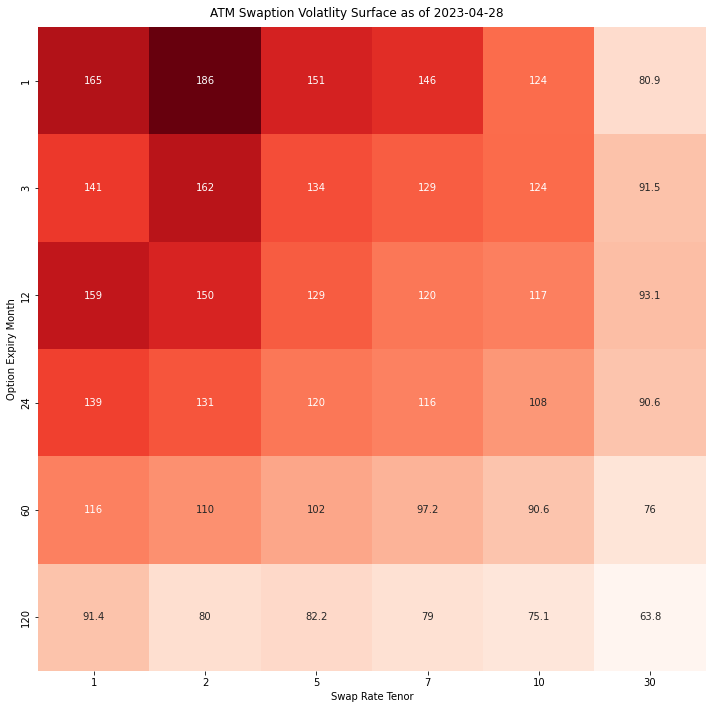

In [31]:
fig, axes = plt.subplots(figsize = (10,10))

sns.heatmap(
    data = (df_prep.query(
        "date == date.max()").
        drop(columns = ["date", "ticker"]).
        rename(columns = {
            "expiry_month": "Option Expiry Month",
            "tenor_year": "Swap Rate Tenor"}).
        pivot(index = "Option Expiry Month", columns = "Swap Rate Tenor", values = "value")),
    fmt = ".3g",
    annot = True,
    cmap = "Reds",
    cbar = False)

fig.suptitle("ATM Swaption Volatlity Surface as of {}".format(
    df_prep.date.max().date()))
plt.tight_layout()
plt.show()

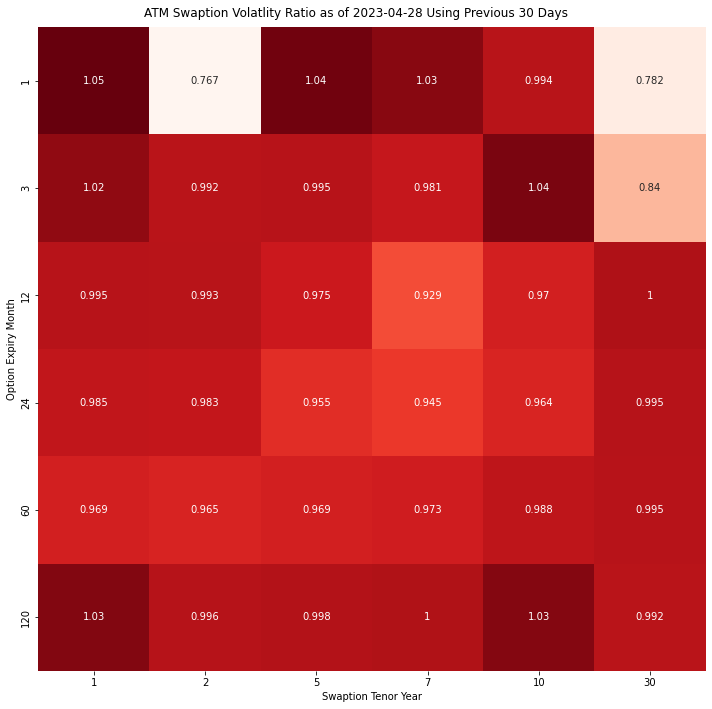

In [45]:
def _shift_back(df):
    return(df.sort_values(
        "date").
        assign(lag_value = lambda x: x.value.shift(30)))

fig, axes = plt.subplots(figsize = (10,10))
sns.heatmap(
    data = (df_prep.groupby(
        "ticker").
        apply(_shift_back).
        query("date == date.max()").
        assign(ratio = lambda x: x.value / x.lag_value)
        [["ratio", "tenor_year", "expiry_month"]].
        rename(columns = {
            "tenor_year": "Swaption Tenor Year",
            "expiry_month": "Option Expiry Month"}).
        pivot(
            index = "Option Expiry Month", 
            columns = "Swaption Tenor Year", 
            values = "ratio")),
    annot = True,
    fmt = ".3g",
    cmap = "Reds",
    cbar = False)

fig.suptitle("ATM Swaption Volatlity Ratio as of {} Using Previous 30 Days".format(
    df_prep.date.max().date()))
plt.tight_layout()
plt.show()

## Make our PCA Input Data

In [46]:
date_max = df_prep.date.max()
date_cutoff = dt.date(year = date_max.year - 2, month = date_max.month, day = date_max.day)
df_wider_raw_value = (df_prep.query(
    "date >= @date_cutoff").
    assign(ticker = lambda x: x.ticker.str.split(" ").str[0])
    [["date", "ticker", "value"]].
    pivot(index = "date", columns = "ticker", values = "value"))

In [48]:
pca_raw = PCA(n_components = 3)
pca_raw_fit = pca_raw.fit(df_wider_raw_value)

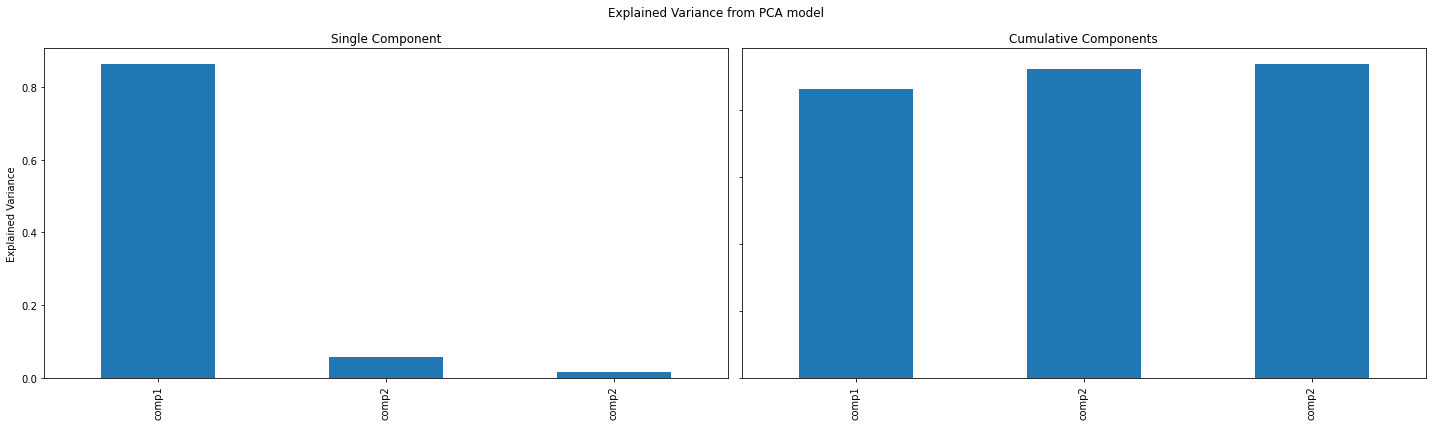

In [58]:
df_explained_variance = (pd.DataFrame({
    "PCA": pca_raw_fit.explained_variance_ratio_,},
    index = ["comp1", "comp2", "comp2"]))
df_explained_cums = df_explained_variance.cumsum()

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20,6))

(df_explained_variance.plot(
    ax = axes[0], kind = "bar",
    title = "Single Component",
    ylabel = "Explained Variance",
    sharey = True,
    legend = False))

(df_explained_cums.plot(
    ax = axes[1], kind = "bar",
    title = "Cumulative Components",
    legend = False))

fig.suptitle("Explained Variance from PCA model")
plt.tight_layout()
plt.show()

In [59]:
pcs = pca_raw_fit.fit_transform(df_wider_raw_value)

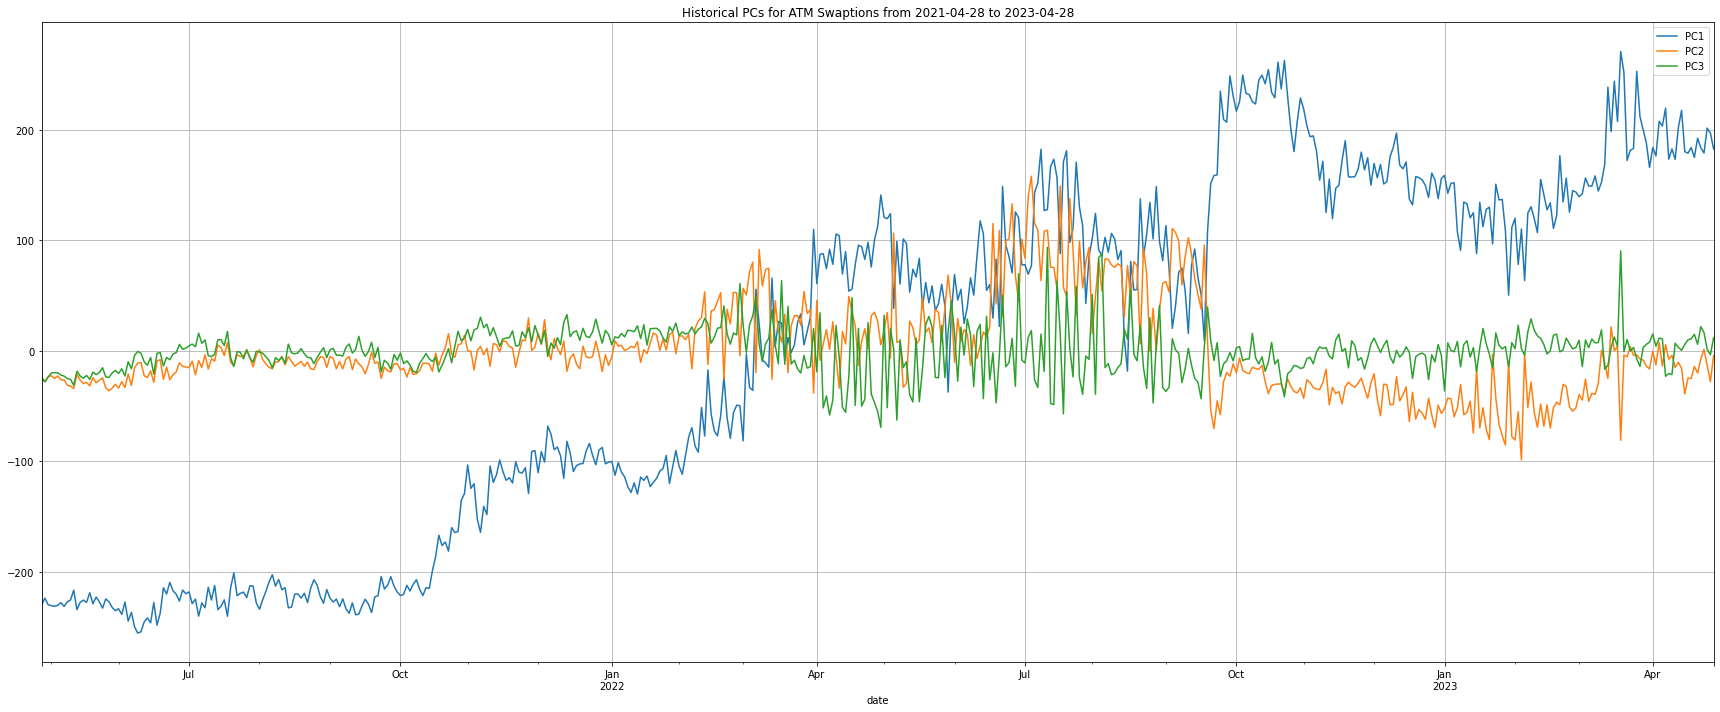

In [61]:
(pd.DataFrame(
    pcs, columns = ["PC1", "PC2", "PC3"],
    index = df_wider_raw_value.index).
    plot(
        figsize = (24,10), grid = True,
        title = "Historical PCs for ATM Swaptions from {} to {}".format(
            df_wider_raw_value.index.min().date(), df_wider_raw_value.index.max().date())))

plt.tight_layout()
plt.show()

In [62]:
df_fitted = (pd.DataFrame(
    data = pca_raw.inverse_transform(pcs),
    index = df_wider_raw_value.index,
    columns = df_wider_raw_value.columns))

In [63]:
df_merged = (df_wider_raw_value.reset_index().melt(
    id_vars = "date").
    rename(columns = {"value": "raw_value"}).
    merge(
        (df_fitted.reset_index().melt(
          id_vars = "date").
          rename(columns = {"value": "fitted_value"})),
        how = "inner",
        on = ["date", "ticker"]))

In [64]:
residuals_df = (df_merged.assign(
    residuals = lambda x: x.raw_value - x.fitted_value)
    [["date", "ticker", "residuals"]].
    pivot(index = "date", columns = "ticker", values = "residuals"))

residuals_zscore = (residuals_df - residuals_df.mean()) / residuals_df.std()

## Making Z-score chart

In [65]:
residuals_zscore_period = (residuals_df.tail(30) - residuals_df.tail(30).mean()) / residuals_df.tail(30).std()

In [66]:
df_last_zscore = (residuals_zscore_period.reset_index().query(
    "date == date.max()").
    melt(id_vars = "date"))

In [67]:
df_last_day = (df_last_zscore.merge(
    (df_prep[
      ["ticker", "tenor_year", "expiry_month"]].
      drop_duplicates().
      rename(columns = {"ticker": "bbg_ticker"}).
      assign(ticker = lambda x: x.bbg_ticker.str.split(" ").str[0])),
    how = "left",
    on = ["ticker"])
    [["value", "tenor_year", "expiry_month"]].
    rename(columns = {
        "tenor_year": "Tenor Year",
        "expiry_month": "Expiry Month"}).
    pivot(index = "Expiry Month", columns = "Tenor Year", values = "value"))

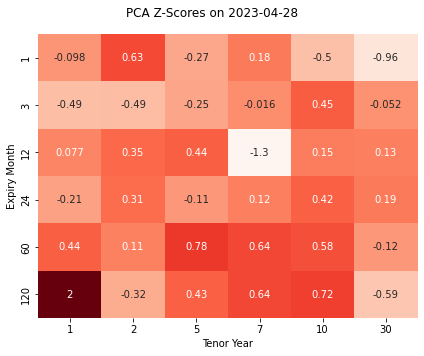

In [68]:
fig, axes = plt.subplots(figsize = (6,5))

sns.heatmap(
    df_last_day,
    ax = axes,
    annot = True,
    cmap = "Reds",
    cbar = False)

fig.suptitle("PCA Z-Scores on {}".format(
    df_last_zscore.date.max().date()))

plt.tight_layout()